# FP
Start writing all my logic in jupyter notebook in order to run them from anaconda! <br>
** IMPORTANT ** <br>
the network cell should only be intialize once! otherwise the program start creating indexes for the variables!!!! 

## index: 
<a id='index'/>

1. READ DATA 
    * Class 
    * files 
2. [Model](#model)
3. [Train](#tr) 
4. [Evaluate](#ev) 
5. [Test](#ts) 
6. [Other](#o)

[go back](#index)

In [1]:
import pandas as pd 
import tensorflow as tf 
import numpy as np 

import requests
import json
import sys
import os
import time
from types import *
from collections import Counter
from datetime import datetime

In [2]:
start = time.time()
start

1508836592.201532

In [3]:
datetime.now().strftime('%H:%M:%S')

'11:16:32'

In [4]:
dataT  = {'label' : [] , 'data' :  [] } #inmutables array are faster! 
dataE  = {'label' : [] , 'data' :  [] }
dataTest = {'label' : [] , 'data' :  [] }; pred_val = []
nout   = 100
ninp   = 0


# Data Read

In [5]:
LOG        = "../../_zfp/LOG.txt"
LOGDIR     = "../../_zfp/data/my_graph/"
LOGDAT     = "../../_zfp/data/"
DSJ        = "/data_json.txt"
DSC        = "/datasc.csv"   
DC         = "/datac.csv"
DL         = "/datal.csv"
DESC       = "FRFLO"
# DESC       = "FRALL1"
dType      = "C1" #C1 or C4
type_sep   = False
spn        = 5000  #5000 -1 = all for training 
filter     = ["", 0]
#---------------------------------------------------------------------
LAB_DS     = LOGDAT + DESC + DL #"../../_zfp/data/FRFLO/datal.csv"
COL_DS     = LOGDAT + DESC + DC 
ALL_DSJ    = LOGDAT + DESC + DSJ 
ALL_DS     = LOGDAT + DESC + DSC 
MMF        = "MOD3" #2(1) OR 5 (4)
MODEL_DIR  = LOGDIR + DESC + '/' + DESC +  MMF +"/model.ckpt"  

def des():  return DESC+'_'+dType+"_filt:"+  filter[0]+str(filter[1])

def c4(df, rv=1):
    if rv == 1:
        if( df < 23 ):                  return [1,0,0,0]  #0
        elif( df >= 23 and df < 60 ):   return [0,1,0,0]  #1
        elif( df >= 60 and df < 93 ):   return [0,0,1,0]  #2
        elif( df >= 93 ):               return [0,0,0,1]  #3    
    elif rf==2: 
        if( df < 23 ):                  return 0
        elif( df >= 23 and df < 60 ):   return 1
        elif( df >= 60 and df < 93 ):   return 2
        elif( df >= 93 ):               return 3
    # elif rf==3: 
    #     if  ( df == [1,0,0,0] ):        return 0 
    #     elif( df == [0,1,0,0] ):        return 1
    #     elif( df == [0,0,1,0] ):        return 2  
    #     elif( df == [0,0,0,1] ):        return 3  
def cN(df):
    global nout
    listofzeros = [0] * nout
    dfIndex = df #//nRange
    # print('{} and {}', (df,dfIndex))
    if    0 < dfIndex < nout:   listofzeros[dfIndex] = 1
    elif  dfIndex < 0:          listofzeros[0]       = 1
    elif  dfIndex >= nout:      listofzeros[nout-1]  = 1
    
    return listofzeros 
# Maybe I can do this with hot-encoder in sckitlearn
def cc(x, rv=1):
    global nout
    if   dType == 'C4':  nout = 4;   return c4(x, rv);
    elif dType == 'C1':  nout = 102; return cN(x); 
def dc(df, val = 1 ): return df.index(val)

def convert_2List(dst): return {'label' : dst["label"].as_matrix().tolist(), 'data' : dst["data"].as_matrix().tolist()}

def get_batches(batch_size):
    n_batches = len(dataT["label"])//batch_size
    # x,y = dataT["data"][:n_batches*batch_size], dataT["label"][:n_batches*batch_size]
    
    for ii in range(0, len(dataT["data"][:n_batches*batch_size] ), batch_size ):
        #convert to list! 
        yield dataT["data"][ii:ii+batch_size], dataT["label"][ii:ii+batch_size]   

def read_data1(data_path,  typeSep = False, filt = "", filtn = 0, pand=True, shuffle = True): 
    global dataT; global dataE;
    #read excel by batchs
    dst = pd.read_csv( tf.gfile.Open(data_path), sep=None, skipinitialspace=True,  engine="python" )
    dst = dst.fillna(0)
    if filt == '>':
            dst = dst[dst["FP"]>filtn]
    elif filt == '<':
        dst = dst[dst["FP"]<filtn]

    dst.insert(2, 'FP_P', dst['FP'].map(lambda x: cc(x)))  
    dataCol = 3 # M F Cx  
    if shuffle: dst = dst.sample(frac=1).reset_index(drop=True) 
    dataT  = {'label' : dst.loc[spn:,'FP_P'] , 'data' :  dst.iloc[spn:, dataCol:] }
    dataE  = {'label' : dst.loc[:spn-1,'FP_P'] , 'data' :  dst.iloc[:spn, dataCol:] }

def mainRead2(path, part, batch_size):  # read by partitions! 
    global ninp, nout, dataT, dataE, spn;
    start = time.time()
    columns = pd.read_csv( tf.gfile.Open(path), sep=None, skipinitialspace=True,  engine="python" ,skiprows=0, nrows=1)
    dst = pd.read_csv( tf.gfile.Open(path), sep=None, skipinitialspace=True,  engine="python" ,skiprows=part*batch_size+1, nrows=batch_size, names = columns.columns)
    dst = dst.fillna(0)

    dst.insert(2, 'FP_P', dst['FP'].map(lambda x: cc( x )))  
    
    if batch_size > spn: spn = -1
    dst = dst.sample(frac=1).reset_index(drop=True) 
    dataT  = {'label' : dst.loc[spn:,'FP_P'] , 'data' :  dst.iloc[spn:, 3:] }
    dataE  = {'label' : dst.loc[:spn-1,'FP_P'] , 'data' :  dst.iloc[:spn, 3:] }

    elapsed_time = float(time.time() - start)
    print("data read - lenTrain={}-{} & lenEv={}-{} time:{}" .format(len(dataT["data"]), len(dataT["label"]),len(dataE["data"]),len(dataE["label"]), elapsed_time ))
   
    ninp  = len(dataT["data"].columns)

    #dataT= convert_2List(dataT)
    #dataE= convert_2List(dataE)
    return ninp, nout

def mainRead(filt=["", 0]):             
    global ninp, nout, dataT, dataE; 
    print(des())
    
    start = time.time()
    read_data1(ALL_DS, typeSep = type_sep, filt=filt[0], filtn=filt[1] ) 
    elapsed_time = float(time.time() - start)
    print("data read - lenTrain={}-{} & lenEv={}-{} time:{}" .format(len(dataT["data"]), len(dataT["label"]),len(dataE["data"]),len(dataE["label"]),elapsed_time ))

    ninp = len(dataE["data"].columns)
    print("N of columns: {}" .format( str(ninp) ) )
    dataT= convert_2List(dataT)
    dataE= convert_2List(dataE)
    return ninp, nout

def check_perf_CN(predv, dataEv, sk_ev=False ):
    gt3 = 0; gtM = 0; 
    # predvList = predv.tolist()
    # assert(len(predv) == len(dataEv['label']))
    print("denormalization all Evaluation : {} = {}" .format(len(predv), len(dataEv["label"])))
    #for i in range(100):
    for i in range(len(predv)):
        if (i % 1000==0): print(str(i)) #, end="__") 
        try:
            pred_v = dc( predv.tolist()[i], np.max(predv[i]))
            data_v = dataEv['label'][i] if sk_ev  else dc( dataEv['label'][i])
            if   dType == 'C4' and pred_v != data_v:  gt3=gtM=gtM+1
            elif dType == 'C1':
                num = abs(pred_v-data_v)
                if num > 3: gt3+=1
                if num > 10: gtM+=1
        except: print("error: i={}, pred={}, data={} -- ".format(i, pred_v, data_v))
    print("Total: {} GT3: {}  GTM: {}".format(len(predv), gt3, gtM)) 
    return gt3, gtM 

def feed_data(dataJJ, p_abs, d_st = False, p_exp=False, pand=False):
    indx=[];   index_col=0 if p_abs else 2 
 
    # col_df = pd.read_csv(COL_DS, index_col=index_col, sep=',', usecols=[0,1,2,3])    
    col_df = pd.read_csv(COL_DS, index_col=index_col, sep=',', usecols=[0,1,2])    
    print("input-no={}".format( len(col_df )))
    
    if p_exp:   indx.append(i for i in range(103))
    else:       indx = col_df.index
    
    json_df  = pd.DataFrame(columns=indx); df_entry = pd.Series(index=indx)
    df_entry = df_entry.fillna(0) 
   
    ccount = Counter()
    if(isinstance(dataJJ, list)):json_data = dataJJ
    else: json_str=open(dataJJ).read();  json_data = json.loads(json_str)
    # for i in range(20):
    for i in range(len(json_data)): # print(i)
        df_entry *= 0
        m = str(json_data[i]["m"])
        df_entry.name = m
        for key in json_data[i]:
            if key == "m": pass            
            else: 
                key_wz = key if p_abs else (int(key))  #str(int(key)) FRFLO - int // FRALL str!
                try: #filling of key - experimental or COMP 
                    ds_comp = col_df.loc[key_wz]
                    if p_exp == True:  #fp key - 0-102   
                        co = str(ds_comp['FP'])
                        if co == 'nan':  col_key = 102
                        else: 
                            col_key = int(ds_comp['FP'])
                            if col_key>101: col_key = 101
                            if col_key<0: col_key = 0
                    else: col_key = key_wz      
                    # df_entry.loc[col_key]
                    df_entry[col_key] =  np.float32(json_data[i][key])
                except: 
                    if d_st: print("m:{}-c:{} not included" .format(m, key_wz)); ccount[key_wz] +=1

        json_df = json_df.append(df_entry,ignore_index=False)
        if i % 1000 == 0: print("cycle: {}".format(i))
    
    print("Counter of comp. not included :"); print(ccount) # print(len(ccount))

    if pand == True:  return json_df  
    else:             return json_df.as_matrix().tolist()  

In [6]:
print("___Start!___" +  datetime.now().strftime('%H:%M:%S')  )
# spn = 200
DESC = "FRFLO"
# ninp, nout  = mainRead()
# For test I am forced to used JSON - column names and order may be different! 
#  md.DESC     = "FREXP"
# ninp, nout  = mainRead2()
print("___Data Read!")

___Start!___11:16:34
___Data Read!


In [7]:
# read_data1(ALL_DS, typeSep = type_sep ) 
# dataE["data"][0:1]
# dataE["data"]
# ninp, nout  = mainRead2(ALL_DS, 0, 2 )
ninp, nout  = mainRead()


FRFLO_C1_filt:0
data read - lenTrain=4610-4610 & lenEv=5000-5000 time:6.04760479927063
N of columns: 1814


# Pandas tests

In [8]:
# test reshape to analyse components with the normal input 
# dataE['data'].loc[0]
# dataE['data']['100202'][0]
# dataE['label']
# print(len(dataE))


In [9]:
lr         = 0.01
h          = [100 , 40]


# Network 

In [10]:
def get_nns(): return str(ninp)+'*'+str(h[0])+'*'+str(h[1])+'*'+str(nout)
def logr(datep = '' , time='', it=1000, nn='', typ='TR', DS='', AC=0, num=0, AC3=0, AC10=0, desc='', startTime=''):
    if desc == '': print("Log not recorded"); return 
    LOG = "../../_zfp/LOGT2.txt"
    f= open(LOG ,"a+") #w,a,
    if datep != '':   dats = datep
    else:             dats = datetime.now().strftime('%d.%m.%Y') 
    if time != '':    times = time
    else:             times = datetime.now().strftime('%H:%M:%S') 

    line =  datetime.now().strftime('%d.%m.%Y') + '\t' + times 
    line = line + '\t' + str(it) + '\t'+  get_nns() +  '\t' + str(lr)
    line = line + '\t' + typ 
    line = line + '\t' + str(DS) + '\t' + str(AC) + '\t' + str(num) + '\t' + str(AC3) + '\t' +  str(AC10) + '\t' + desc 
    line = line + '\t' + str(batch_size) + '\t' +  startTime + '\n' #new

    f.write(line);  f.close()
    print("___Log recorded")    

In [11]:
print( get_nns() )
x = tf.placeholder(tf.float32,   shape=[None, ninp], name="x")
y = tf.placeholder(tf.int16,     shape=[None, nout], name="y")

def build_network3():                   # RNN logic mix with NN - 
    pass
def build_network2(is_train=False):     # Simple NN - with batch normalization (high level)
    kp = 0.9

    # h0 = tf.layers.dense( x, h[0], activation=tf.nn.relu,  name )
    h0 = tf.layers.dense( x, h[0], use_bias=False, activation=None )
    h0 = tf.layers.batch_normalization(h0, training=is_train)
    h0 = tf.nn.relu(h0)
    # h0 = tf.nn.dropout(h0, kp)
    
    h1 = tf.layers.dense( h0, h[1], use_bias=False, activation=None )
    h1 = tf.layers.batch_normalization(h1, training=is_train)
    h1 = tf.nn.relu(h1)
    # h1 = tf.nn.dropout(h1, kp)
    
    out = tf.layers.dense( h1, nout, use_bias=False, activation=None )
    out = tf.layers.batch_normalization(out, training=is_train)
    out = tf.nn.relu(out)
    # out = tf.nn.dropout(h0, kp)
 
    # softmaxT = tf.nn.softmax(out)
    softmaxT = tf.nn.top_k(tf.nn.softmax(out), 4)
            
    prediction=tf.reduce_max(y,1)
    correct_prediction = tf.equal(tf.argmax(out, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return out, accuracy, softmaxT

1814*100*40*102


In [12]:
prediction, accuracy, softmaxT = build_network2()


# TESTS

In [13]:
def restore_model(sess):   
    saver= tf.train.Saver() 
    print("Model restored from file: %s" % model_path)
    saver.restore(sess, model_path)
def train(it = 100, disp=50, batch_size = 128): 
    print("____TRAINING...")
    display_step =  disp 
    total_batch  = int(len(dataT['label']) / batch_size)
    
    with tf.name_scope("xent"):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y))
        tf.summary.scalar("xent", cost)

    with tf.name_scope("train"):
        optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
    startTime = datetime.now().strftime('%H:%M:%S')
    summ = tf.summary.merge_all()
    saver= tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        # restore_model(sess)  #Run if I want to retrain an existing model
        start = time.time()
        for i in range(it):            
            for ii, (xtb,ytb) in enumerate(get_batches(batch_size) ):
                # xtb, ytb = dc.next_batch(batch_size, dataT['data'], dataT['label'])
                sess.run(optimizer, feed_dict={x: xtb, y: ytb})
                if ii % display_step ==0: #record_step == 0:
                    [train_accuracy] = sess.run([accuracy], feed_dict={x: xtb, y: ytb }) 
                    elapsed_time = float(time.time() - start)
                    reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
                    rp_s = str(reviews_per_second)[0:5]
                    tr_ac = str(train_accuracy)[:5]  
                    print('Epoch: {} batch: {} / {} - %Speed(it/disp_step): {} - tr_ac {}' .format(i, ii, total_batch, rp_s, tr_ac ))
                    #writer.add_summary(s, i)
            ev_ac = str(sess.run(accuracy, feed_dict={x: dataE['data'], y: dataE['label']}))[:5] 
            print("E Ac:", ev_ac)
        
        tr_ac = str(sess.run(accuracy, feed_dict={x: dataT['data'], y: dataT['label']}))[:5] 
        print("T Ac:", tr_ac)
        
        save_path = saver.save(sess, model_path)
        print("Model saved in file: %s" % save_path) 
    print("Optimization Finished!")

    logr( it=it, typ='TR', DS=DESC, AC=tr_ac,num=len(dataT["label"]), AC3=0, AC10=0, desc=des(), startTime=startTime )
    logr( it=it, typ='EV', DS=DESC, AC=ev_ac,num=len(dataE["label"]), AC3=0, AC10=0, desc=des() )
def evaluate( ): 
    print("_____EVALUATION...")
    startTime = datetime.now().strftime('%H:%M:%S')

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        restore_model(sess)
        # test the model
        tr_ac = str(sess.run( accuracy, feed_dict={ x: dataT['data'],  y: dataT['label']}) )[:5]  
        ev_ac = str(sess.run( accuracy, feed_dict={ x: dataE['data'],  y: dataE['label'][:spn]   }))[:5] 
        print("Training   Accuracy:", tr_ac )
        print("Evaluation Accuracy:", ev_ac )
        # xtp1.append(dataTest['data'][i]);    ytp1.append(dataTest['label'][i])
        predv, softv = sess.run([prediction, softmaxT], feed_dict={x: dataE['data']  }) # , y: dataE['label'] 
        # maxa = sess.run([prediction], feed_dict={y: predv })
    print("Preview the first predictions:")
    for i in range(20):
        print("RealVal: {}  - PP value: {}".format( dc( dataE['label'][i]), 
                                                    dc( predv.tolist()[i], np.max(predv[i]))  ))
    gt3, gtM = check_perf_CN(predv, dataE, False)
    logr(  it=0, typ='EV', AC=ev_ac,DS=DESC, num=len(dataE["label"]), AC3=gt3, AC10=gtM, desc=des(), startTime=startTime )
def tests(url_test = 'url'):  
    print("_____TESTS...")        
    if url_test != 'url':  
        json_data = url_test + "data_json6.txt"
        tmpLab = pd.read_csv(url_test + "datal6.csv", sep=',', usecols=[0,1])    
        tmpLab = tmpLab.loc[:,'fp']
        abstcc = False
    else: 
        json_str, tmpLab = get_data_test("FRALL")
        json_data = json.loads(json_str)
        abstcc = True
        DESC =  'matnrList...'
    dataTest['data']  = feed_data(json_data, p_abs=abstcc , d_st=True)
    dataTest['label'] = []
    [dataTest['label'].append( cc(x) ) for x in tmpLab ]

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        restore_model(sess)
        # predv = sess.run( prediction, feed_dict={x: dataTest['data']}) 
        ts_acn = '0'
        ts_acn, predv, sf = sess.run( [accuracy, prediction, softmaxT], feed_dict={x: dataTest['data'], y: dataTest['label']}) 
        ts_ac = str(ts_acn) 
        print("test ac = {}".format(ts_ac))
    # print(dataTest['label'])
    print(sf)
    range_ts = len(predv) if len(predv)<20 else 20
    for i in range( range_ts ):
        print("RealVal: {}  - PP value: {}".format( dc( dataTest['label'][i]), dc( predv.tolist()[i], np.max(predv[i]))  ))  
    
    gt3, gtM = check_perf_CN(predv, dataTest, False)
    logr( it=0, typ='TS', DS="FREXP1_6", AC=ts_acn ,num=len(dataTest["label"]),  AC3=gt3, AC10=gtM, desc=des() )  


In [14]:
len(dataT['data'])

4610

# MAIN

In [15]:
# md.MODEL_DIR  = sss
model_path    = MODEL_DIR 
epochs     = 100
disp       = 5
batch_size = 128
url_test = "../../_zfp/data/FREXP1/" ; DESC  = "FREXP1_6"


In [24]:

train(epochs, disp, batch_size)
evaluate( )
tests(url_test  )


print("___The end!")

____TRAINING...
Epoch: 0 batch: 0 / 36 - %Speed(it/disp_step): 0.0 - tr_ac 0.046
Epoch: 0 batch: 5 / 36 - %Speed(it/disp_step): 0.0 - tr_ac 0.039
Epoch: 0 batch: 10 / 36 - %Speed(it/disp_step): 0.0 - tr_ac 0.046
Epoch: 0 batch: 15 / 36 - %Speed(it/disp_step): 0.0 - tr_ac 0.031
Epoch: 0 batch: 20 / 36 - %Speed(it/disp_step): 0.0 - tr_ac 0.039
Epoch: 0 batch: 25 / 36 - %Speed(it/disp_step): 0.0 - tr_ac 0.062
Epoch: 0 batch: 30 / 36 - %Speed(it/disp_step): 0.0 - tr_ac 0.070
Epoch: 0 batch: 35 / 36 - %Speed(it/disp_step): 0.0 - tr_ac 0.101
E Ac: 0.058
Epoch: 1 batch: 0 / 36 - %Speed(it/disp_step): 0.846 - tr_ac 0.062
Epoch: 1 batch: 5 / 36 - %Speed(it/disp_step): 0.783 - tr_ac 0.046
Epoch: 1 batch: 10 / 36 - %Speed(it/disp_step): 0.725 - tr_ac 0.109
Epoch: 1 batch: 15 / 36 - %Speed(it/disp_step): 0.675 - tr_ac 0.070
Epoch: 1 batch: 20 / 36 - %Speed(it/disp_step): 0.633 - tr_ac 0.062
Epoch: 1 batch: 25 / 36 - %Speed(it/disp_step): 0.594 - tr_ac 0.078
Epoch: 1 batch: 30 / 36 - %Speed(it/disp

Epoch: 14 batch: 35 / 36 - %Speed(it/disp_step): 0.810 - tr_ac 0.414
E Ac: 0.140
Epoch: 15 batch: 0 / 36 - %Speed(it/disp_step): 0.848 - tr_ac 0.445
Epoch: 15 batch: 5 / 36 - %Speed(it/disp_step): 0.843 - tr_ac 0.476
Epoch: 15 batch: 10 / 36 - %Speed(it/disp_step): 0.839 - tr_ac 0.476
Epoch: 15 batch: 15 / 36 - %Speed(it/disp_step): 0.834 - tr_ac 0.453
Epoch: 15 batch: 20 / 36 - %Speed(it/disp_step): 0.830 - tr_ac 0.359
Epoch: 15 batch: 25 / 36 - %Speed(it/disp_step): 0.825 - tr_ac 0.398
Epoch: 15 batch: 30 / 36 - %Speed(it/disp_step): 0.820 - tr_ac 0.554
Epoch: 15 batch: 35 / 36 - %Speed(it/disp_step): 0.816 - tr_ac 0.398
E Ac: 0.134
Epoch: 16 batch: 0 / 36 - %Speed(it/disp_step): 0.851 - tr_ac 0.484
Epoch: 16 batch: 5 / 36 - %Speed(it/disp_step): 0.847 - tr_ac 0.5
Epoch: 16 batch: 10 / 36 - %Speed(it/disp_step): 0.843 - tr_ac 0.406
Epoch: 16 batch: 15 / 36 - %Speed(it/disp_step): 0.838 - tr_ac 0.476
Epoch: 16 batch: 20 / 36 - %Speed(it/disp_step): 0.834 - tr_ac 0.390
Epoch: 16 batch:

Epoch: 29 batch: 20 / 36 - %Speed(it/disp_step): 0.858 - tr_ac 0.523
Epoch: 29 batch: 25 / 36 - %Speed(it/disp_step): 0.855 - tr_ac 0.632
Epoch: 29 batch: 30 / 36 - %Speed(it/disp_step): 0.853 - tr_ac 0.664
Epoch: 29 batch: 35 / 36 - %Speed(it/disp_step): 0.850 - tr_ac 0.671
E Ac: 0.140
Epoch: 30 batch: 0 / 36 - %Speed(it/disp_step): 0.866 - tr_ac 0.648
Epoch: 30 batch: 5 / 36 - %Speed(it/disp_step): 0.863 - tr_ac 0.656
Epoch: 30 batch: 10 / 36 - %Speed(it/disp_step): 0.860 - tr_ac 0.687
Epoch: 30 batch: 15 / 36 - %Speed(it/disp_step): 0.857 - tr_ac 0.648
Epoch: 30 batch: 20 / 36 - %Speed(it/disp_step): 0.854 - tr_ac 0.562
Epoch: 30 batch: 25 / 36 - %Speed(it/disp_step): 0.852 - tr_ac 0.609
Epoch: 30 batch: 30 / 36 - %Speed(it/disp_step): 0.849 - tr_ac 0.656
Epoch: 30 batch: 35 / 36 - %Speed(it/disp_step): 0.847 - tr_ac 0.656
E Ac: 0.134
Epoch: 31 batch: 0 / 36 - %Speed(it/disp_step): 0.865 - tr_ac 0.671
Epoch: 31 batch: 5 / 36 - %Speed(it/disp_step): 0.863 - tr_ac 0.664
Epoch: 31 batc

Epoch: 44 batch: 10 / 36 - %Speed(it/disp_step): 0.851 - tr_ac 0.734
Epoch: 44 batch: 15 / 36 - %Speed(it/disp_step): 0.849 - tr_ac 0.710
Epoch: 44 batch: 20 / 36 - %Speed(it/disp_step): 0.847 - tr_ac 0.585
Epoch: 44 batch: 25 / 36 - %Speed(it/disp_step): 0.846 - tr_ac 0.687
Epoch: 44 batch: 30 / 36 - %Speed(it/disp_step): 0.844 - tr_ac 0.734
Epoch: 44 batch: 35 / 36 - %Speed(it/disp_step): 0.842 - tr_ac 0.687
E Ac: 0.119
Epoch: 45 batch: 0 / 36 - %Speed(it/disp_step): 0.854 - tr_ac 0.734
Epoch: 45 batch: 5 / 36 - %Speed(it/disp_step): 0.852 - tr_ac 0.695
Epoch: 45 batch: 10 / 36 - %Speed(it/disp_step): 0.851 - tr_ac 0.718
Epoch: 45 batch: 15 / 36 - %Speed(it/disp_step): 0.849 - tr_ac 0.75
Epoch: 45 batch: 20 / 36 - %Speed(it/disp_step): 0.847 - tr_ac 0.625
Epoch: 45 batch: 25 / 36 - %Speed(it/disp_step): 0.845 - tr_ac 0.679
Epoch: 45 batch: 30 / 36 - %Speed(it/disp_step): 0.844 - tr_ac 0.734
Epoch: 45 batch: 35 / 36 - %Speed(it/disp_step): 0.842 - tr_ac 0.710
E Ac: 0.111
Epoch: 46 bat

Epoch: 58 batch: 35 / 36 - %Speed(it/disp_step): 0.843 - tr_ac 0.734
E Ac: 0.108
Epoch: 59 batch: 0 / 36 - %Speed(it/disp_step): 0.852 - tr_ac 0.726
Epoch: 59 batch: 5 / 36 - %Speed(it/disp_step): 0.851 - tr_ac 0.75
Epoch: 59 batch: 10 / 36 - %Speed(it/disp_step): 0.849 - tr_ac 0.742
Epoch: 59 batch: 15 / 36 - %Speed(it/disp_step): 0.848 - tr_ac 0.703
Epoch: 59 batch: 20 / 36 - %Speed(it/disp_step): 0.847 - tr_ac 0.609
Epoch: 59 batch: 25 / 36 - %Speed(it/disp_step): 0.845 - tr_ac 0.679
Epoch: 59 batch: 30 / 36 - %Speed(it/disp_step): 0.844 - tr_ac 0.726
Epoch: 59 batch: 35 / 36 - %Speed(it/disp_step): 0.843 - tr_ac 0.765
E Ac: 0.112
Epoch: 60 batch: 0 / 36 - %Speed(it/disp_step): 0.852 - tr_ac 0.742
Epoch: 60 batch: 5 / 36 - %Speed(it/disp_step): 0.851 - tr_ac 0.718
Epoch: 60 batch: 10 / 36 - %Speed(it/disp_step): 0.850 - tr_ac 0.757
Epoch: 60 batch: 15 / 36 - %Speed(it/disp_step): 0.849 - tr_ac 0.718
Epoch: 60 batch: 20 / 36 - %Speed(it/disp_step): 0.847 - tr_ac 0.648
Epoch: 60 batch

Epoch: 73 batch: 25 / 36 - %Speed(it/disp_step): 0.840 - tr_ac 0.734
Epoch: 73 batch: 30 / 36 - %Speed(it/disp_step): 0.838 - tr_ac 0.781
Epoch: 73 batch: 35 / 36 - %Speed(it/disp_step): 0.837 - tr_ac 0.804
E Ac: 0.130
Epoch: 74 batch: 0 / 36 - %Speed(it/disp_step): 0.845 - tr_ac 0.75
Epoch: 74 batch: 5 / 36 - %Speed(it/disp_step): 0.844 - tr_ac 0.773
Epoch: 74 batch: 10 / 36 - %Speed(it/disp_step): 0.843 - tr_ac 0.789
Epoch: 74 batch: 15 / 36 - %Speed(it/disp_step): 0.842 - tr_ac 0.757
Epoch: 74 batch: 20 / 36 - %Speed(it/disp_step): 0.840 - tr_ac 0.656
Epoch: 74 batch: 25 / 36 - %Speed(it/disp_step): 0.839 - tr_ac 0.734
Epoch: 74 batch: 30 / 36 - %Speed(it/disp_step): 0.838 - tr_ac 0.781
Epoch: 74 batch: 35 / 36 - %Speed(it/disp_step): 0.837 - tr_ac 0.812
E Ac: 0.128
Epoch: 75 batch: 0 / 36 - %Speed(it/disp_step): 0.844 - tr_ac 0.773
Epoch: 75 batch: 5 / 36 - %Speed(it/disp_step): 0.843 - tr_ac 0.773
Epoch: 75 batch: 10 / 36 - %Speed(it/disp_step): 0.842 - tr_ac 0.773
Epoch: 75 batch

Epoch: 88 batch: 10 / 36 - %Speed(it/disp_step): 0.844 - tr_ac 0.789
Epoch: 88 batch: 15 / 36 - %Speed(it/disp_step): 0.843 - tr_ac 0.781
Epoch: 88 batch: 20 / 36 - %Speed(it/disp_step): 0.843 - tr_ac 0.648
Epoch: 88 batch: 25 / 36 - %Speed(it/disp_step): 0.842 - tr_ac 0.718
Epoch: 88 batch: 30 / 36 - %Speed(it/disp_step): 0.841 - tr_ac 0.781
Epoch: 88 batch: 35 / 36 - %Speed(it/disp_step): 0.840 - tr_ac 0.812
E Ac: 0.121
Epoch: 89 batch: 0 / 36 - %Speed(it/disp_step): 0.846 - tr_ac 0.765
Epoch: 89 batch: 5 / 36 - %Speed(it/disp_step): 0.846 - tr_ac 0.765
Epoch: 89 batch: 10 / 36 - %Speed(it/disp_step): 0.845 - tr_ac 0.789
Epoch: 89 batch: 15 / 36 - %Speed(it/disp_step): 0.844 - tr_ac 0.765
Epoch: 89 batch: 20 / 36 - %Speed(it/disp_step): 0.843 - tr_ac 0.656
Epoch: 89 batch: 25 / 36 - %Speed(it/disp_step): 0.843 - tr_ac 0.710
Epoch: 89 batch: 30 / 36 - %Speed(it/disp_step): 0.842 - tr_ac 0.765
Epoch: 89 batch: 35 / 36 - %Speed(it/disp_step): 0.841 - tr_ac 0.804
E Ac: 0.123
Epoch: 90 ba

m:632416-c:192114 not included
m:632416-c:131306 not included
m:632416-c:600180 not included
m:632416-c:100182 not included
m:632416-c:614552 not included
m:632416-c:107714 not included
m:632416-c:131305 not included
m:632416-c:107159 not included
m:632416-c:181023 not included
m:632416-c:107353 not included
m:632416-c:600237 not included
m:632416-c:106148 not included
m:632416-c:131026 not included
m:632416-c:104557 not included
m:632416-c:104774 not included
m:632416-c:600247 not included
m:632416-c:104814 not included
m:632632-c:906195 not included
m:632632-c:906234 not included
m:632632-c:178713 not included
m:632632-c:904987 not included
m:632632-c:906246 not included
m:632632-c:906228 not included
m:632632-c:643368 not included
m:632632-c:905210 not included
m:632632-c:900081 not included
m:632632-c:104241 not included
m:633650-c:178429 not included
m:633652-c:178429 not included
m:634190-c:656991 not included
m:634190-c:613113 not included
m:634190-c:657531 not included
m:634190

In [16]:
json_data = url_test + "data_json6.txt"
tmpLab = pd.read_csv(url_test + "datal6.csv", sep=',', usecols=[0,1])    
tmpLab = tmpLab.loc[:,'fp']
abstcc = False
dataTest['data']  = feed_data(json_data, p_abs=abstcc , d_st=False)
dataTest['label'] = []
[dataTest['label'].append( cc(x) ) for x in tmpLab ]
print("test read")

input-no=1814
cycle: 0
Counter of comp. not included :
Counter()
test read


In [17]:
len(dataTest['data']) 
len(dataTest['label']) 

984

In [18]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    restore_model(sess)
    # predv = sess.run( prediction, feed_dict={x: dataTest['data']}) 
    ts_acn = '0'
    ts_acn, predv, sf = sess.run( [accuracy, prediction, softmaxT], feed_dict={x: dataTest['data'], y: dataTest['label']}) 
    ts_ac = str(ts_acn) 
    print("test ac = {}".format(ts_ac))
# print(dataTest['label'])
print(sf)
range_ts = len(predv) if len(predv)<20 else 20



Model restored from file: ../../_zfp/data/my_graph/FRFLO/FRFLOMOD3/model.ckpt
INFO:tensorflow:Restoring parameters from ../../_zfp/data/my_graph/FRFLO/FRFLOMOD3/model.ckpt
test ac = 0.0884146
TopKV2(values=array([[  9.80392192e-03,   9.80392192e-03,   9.80392192e-03,
          9.80392192e-03],
       [  9.99499202e-01,   5.00816386e-04,   7.93983869e-18,
          5.48366663e-29],
       [  8.95064712e-01,   6.26118332e-02,   4.19804342e-02,
          2.65040871e-04],
       ..., 
       [  7.21557438e-01,   2.68859088e-01,   9.58341733e-03,
          1.36174814e-08],
       [  9.99959111e-01,   3.99786259e-05,   7.15325029e-07,
          1.35494247e-07],
       [  1.00000000e+00,   1.64745145e-11,   6.23777332e-12,
          5.21078103e-12]], dtype=float32), indices=array([[ 0,  1,  2,  3],
       [94, 95, 99, 90],
       [87, 81, 92, 95],
       ..., 
       [75, 76, 79, 71],
       [80, 79, 81, 76],
       [83, 82, 89, 90]]))


In [19]:
i = 18
print("  PP: {} PR: {} ". format(   sf[1][i], sf[0][i]    ))

  PP: [75 80 71 79] PR: [ 0.87685311  0.09497879  0.01732371  0.00142888] 


In [20]:
for i in range( range_ts ):
    print("{} RealVal: {} - {} - PP: {} PR: {}".format( i, dc( dataTest['label'][i]), sf[1][i][0],  sf[1][i], sf[0][i]   ))

# countTT = 0 
# for i in range(len(predv) ):
#     print("{} RealVal: {}  - PP value: {}".format( i, dc( dataTest['label'][i]), dc( predv.tolist()[i], np.max(predv[i]))  ))
#     if dc( dataTest['label'][i]) != sf[1][i][0]:
#         print("{} RealVal: {} - {} - PP: {} PR: {}".format( i, dc( dataTest['label'][i]), sf[1][i][0],  sf[1][i], sf[0][i]   ))
#         countTT +=1 
# print(countTT)


0 RealVal: 54 - 0 - PP: [0 1 2 3] PR: [ 0.00980392  0.00980392  0.00980392  0.00980392]
1 RealVal: 101 - 94 - PP: [94 95 99 90] PR: [  9.99499202e-01   5.00816386e-04   7.93983869e-18   5.48366663e-29]
2 RealVal: 88 - 87 - PP: [87 81 92 95] PR: [  8.95064712e-01   6.26118332e-02   4.19804342e-02   2.65040871e-04]
3 RealVal: 87 - 93 - PP: [93 90 95 91] PR: [ 0.98654777  0.00259388  0.00248072  0.0013555 ]
4 RealVal: 80 - 0 - PP: [0 1 2 3] PR: [ 0.00980392  0.00980392  0.00980392  0.00980392]
5 RealVal: 101 - 95 - PP: [95 96 97 91] PR: [  1.00000000e+00   5.55999375e-19   1.33277162e-25   8.34116253e-26]
6 RealVal: 97 - 92 - PP: [92 93 98 96] PR: [ 0.87080526  0.03655184  0.01821652  0.00406806]
7 RealVal: 90 - 90 - PP: [90 93 99 91] PR: [ 0.82182807  0.11164241  0.04431251  0.01163928]
8 RealVal: 96 - 96 - PP: [96 98 91 95] PR: [  9.99991775e-01   5.58257670e-06   2.22192375e-06   3.17538706e-07]
9 RealVal: 88 - 80 - PP: [80 81 82 84] PR: [ 0.58042574  0.16529223  0.01732381  0.01166792

In [21]:
# dataTest['data'][131] 
# dataTest['label'][131] 


# Read components

In [59]:
# indx=[];   
p_abs = False
index_col=0 if p_abs else 2 
name_col = "cc" if p_abs else "abs"

# col_df = pd.read_csv(COL_DS, index_col=index_col, sep=',', usecols=[0,1,2,3])    
col_df = pd.read_csv(COL_DS, index_col=index_col, sep=',', usecols=[0,1,2,3])    
print("input-no={}".format( len(col_df )))
col_df.iloc[0]
col_df.iloc[0].name


input-no=1814


100023

In [73]:
col_df = col_df.fillna(0)

dataTest['label'] = []
dataJJ = "["
for i in range(len(col_df)): 
    #lab = col_df.iloc[i]["fp"] if col_df.iloc[i]["fp"] != 'NaN' else 0 
    dataTest['label'].append( cc( int(  col_df.iloc[i]["fp"]  )  )) 
    dataJJ += "{m:"+str(i)+","+str(col_df.iloc[i].name)+":1},"
dataJJ += "]"
# dataJJ[-1] = ""
# print(dataJJ)
col_df.describe()
# dataTest['label']

,tot,fp
count,1814.000000,1814.000000
mean,384.853363,89.188534
std,870.401796,35.392150
min,1.000000,-48.000000
25%,7.000000,68.000000
50%,56.000000,98.000000
75%,297.750000,101.000000
max,8738.000000,300.000000


In [44]:
col_df.iloc[0][name_col]

cc      c1
tot      3
fp     NaN
Name: 100023, dtype: object

In [43]:


# dataTest['data']  = feed_data(json_data, p_abs=abstcc , d_st=False)
# dataTest['label'] = []
# [dataTest['label'].append( cc(x) ) for x in tmpLab ]

# WRITE EXCEL

In [54]:
# import xlsxwriter
# outfile = '../../_zfp/data/export.xlsx' 

# workbook   = xlsxwriter.Workbook(outfile)
# worksheet1 = workbook.add_worksheet()
# worksheet1.write('A1', 'M')
# worksheet1.write(0, 0, 'Hello')  
# for i in range(len(sf[0])):
#     worksheet1.write(0, i , sf[0][i])  
#     worksheet1.write(1, i , sf[1][i]) 

In [55]:
# import csv
# outfile = '../../_zfp/data/export.csv' 
# f2= open(outfile,"a+")
# output_writer = csv.writer(f2, delimiter="\t")
# output_writer.writerows(sf)
# f2.close()

In [57]:
outfile = '../../_zfp/data/export2' 
np.savetxt(outfile + '.csv', sf[1], delimiter=',')
np.savetxt(outfile + 'PRO.csv', sf[0], delimiter=',')

# Display visualizations

In [58]:
path = outfile = '../../_zfp/data/FRFLO/datasc.csv' 
dst  =  pd.read_csv( tf.gfile.Open(path), sep=None, skipinitialspace=True,  engine="python")
Y  = dst.loc[:,'FP'].as_matrix().tolist()
X  = dst.loc[:, 'M'].as_matrix().tolist()

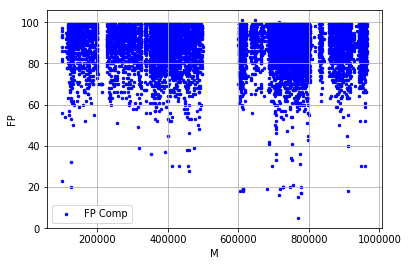

In [82]:
import matplotlib.pyplot as plt
# 2 - Create plot. 
a = 1
if a == 0: 
    plt.hist(Y)
else: 
    plt.xlabel('M')
    plt.ylabel('FP')
    plt.grid(True)
    N = 2 #50
    colors = np.random.rand(N)
    area = 1 #np.pi * (15 * np.random.rand(N))**2  # 0 to 15 point radii

    #plt.plot(X, Y, color='blue', marker='o', label='FP Comp')
    #plt.plot(X, Y, 'bo', label='FP Comp')
    plt.scatter(X,Y, s=6, c='b', marker='o', cmap=None, norm=None, vmin=60, vmax=101, alpha=None,  label='FP Comp')
    # plt.plot(X, Y,  s=area, c=colors, alpha=0.5) #'bo', label='FP Comp',
    plt.legend()

# 3 - Display plot. 

plt.show()